# Tito Nicola Drugman - 502252 - Market Basket Analysis

Dataset: https://www.kaggle.com/datasets/prasad22/retail-transactions-dataset?select=Retail_Transactions_Dataset.csv

Dataset Glossary (Column-wise)

- Transaction Details - Each row represents a transaction, including a unique transaction identifier, date and time, and customer information.
- Product List - A list of products purchased in each transaction.
- Total Items and Cost - Information about the quantity of items and the total cost of each transaction.
- Payment Information - The payment method used for each purchase.
- Location Details - The city and store type where the transaction took place.
- Discounts and Promotions - Indicators of discounts and promotions applied to transactions.
- Customer Insights - A modified column representing customer categories based on background or age group.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from collections import Counter

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

pd.options.display.float_format = '{:.3f}'.format

In [39]:
df_raw = pd.read_csv('Retail_Transactions_Dataset.csv')
df_raw = shuffle(df_raw, random_state=42)

In [40]:
df_raw.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
987231,1000987231,2023-05-23 18:07:20,Jacqueline Maynard,"['Pancake Mix', 'Coffee', 'Ice Cream']",3,16.630,Credit Card,Houston,Specialty Store,True,Middle-Aged,Winter,NaN
79954,1000079954,2022-03-10 16:47:15,David White,['Cleaning Spray'],5,7.460,Debit Card,Miami,Supermarket,False,Middle-Aged,Fall,BOGO (Buy One Get One)
567130,1000567130,2022-07-22 17:02:17,Dr. Thomas Edwards,"['Salmon', 'Garden Hose', 'Deodorant', 'Air Fr...",9,52.270,Cash,Boston,Warehouse Club,True,Teenager,Fall,BOGO (Buy One Get One)
500891,1000500891,2022-04-21 15:14:38,Kristin Collins,"['Power Strips', 'Tuna']",5,25.440,Cash,Los Angeles,Convenience Store,False,Homemaker,Spring,NaN
55399,1000055399,2023-05-03 05:26:02,Robert Finley,"['Cereal', 'Cheese', 'Yogurt', 'Sponges', 'Chi...",6,86.050,Credit Card,Atlanta,Pharmacy,False,Professional,Fall,BOGO (Buy One Get One)


In [41]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 987231 to 121958
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Transaction_ID     1000000 non-null  int64  
 1   Date               1000000 non-null  object 
 2   Customer_Name      1000000 non-null  object 
 3   Product            1000000 non-null  object 
 4   Total_Items        1000000 non-null  int64  
 5   Total_Cost         1000000 non-null  float64
 6   Payment_Method     1000000 non-null  object 
 7   City               1000000 non-null  object 
 8   Store_Type         1000000 non-null  object 
 9   Discount_Applied   1000000 non-null  bool   
 10  Customer_Category  1000000 non-null  object 
 11  Season             1000000 non-null  object 
 12  Promotion          666057 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 100.1+ MB


In [42]:
df_raw.duplicated().sum()

0

In [43]:
df_clean = df_raw.copy()

In [44]:
df_clean = df_clean.drop(['Customer_Name','Total_Items','Total_Cost', 'Payment_Method', 'City', 'Discount_Applied', 'Customer_Category', 'Season', 'Promotion'],axis=1)


In [45]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 987231 to 121958
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Transaction_ID  1000000 non-null  int64 
 1   Date            1000000 non-null  object
 2   Product         1000000 non-null  object
 3   Store_Type      1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 38.1+ MB


In [46]:
def cat_plot_count(df, column_name, color='skyblue', rotation_angle=45):

    counts = df[column_name].value_counts()

    fig, ax = plt.subplots()
    counts.plot(kind='bar', ax=ax, color=color)

    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 1, str(i.get_height()), ha='center', va='bottom')

    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('Count')
    ax.set_title(f'Histogram of {column_name.capitalize()}')

    plt.xticks(rotation=rotation_angle, ha='right')

    plt.tight_layout()
    plt.show()

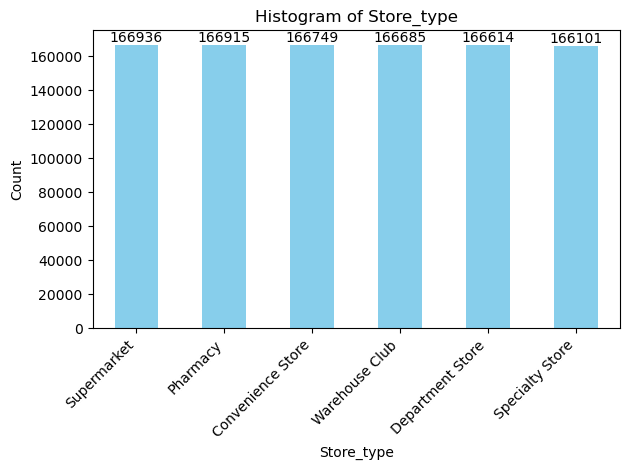

In [47]:
cat_plot_count(df_clean, 'Store_Type')

The dataset is not real and there is no correlation between the Store_Type and the items bought

In [48]:
df_clean = df_clean.drop(['Store_Type'],axis=1)

In [49]:
# There are too many rows, drop some of them
fraction_to_keep = 0.01
df_reduced = df_clean.sample(frac=fraction_to_keep, random_state=42)  # random_state ensures reproducibility

df_reduced.info()
df_clean = df_reduced

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 624588 to 893545
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transaction_ID  10000 non-null  int64 
 1   Date            10000 non-null  object
 2   Product         10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [50]:
df_clean.head()

,Transaction_ID,Date,Product
624588,1000624588,2021-10-30 10:23:22,"['Cereal Bars', 'Eggs', 'Dustpan', 'Mustard', ..."
620810,1000620810,2020-07-11 03:31:50,['Power Strips']
580633,1000580633,2022-11-12 12:57:13,"['Shower Gel', 'Salmon']"
6379,1000006379,2021-09-25 18:17:55,"['Shrimp', 'Bread']"
366511,1000366511,2023-03-11 22:50:40,"['Vinegar', 'Spinach', 'Shampoo', 'Light Bulbs..."


In [51]:
all_products = []

for product_list in df_clean['Product']:
    all_products.extend(eval(product_list))

product_counts = pd.Series(all_products).value_counts()

print(product_counts)

Toothpaste       749
Dish Soap        422
Potatoes         400
Air Freshener    399
Chips            399
                ... 
Apple            335
Dishware         333
Mop              330
Ketchup          322
Cereal Bars      321
Name: count, Length: 81, dtype: int64


In [52]:
print(product_counts.head())

Toothpaste       749
Dish Soap        422
Potatoes         400
Air Freshener    399
Chips            399
Name: count, dtype: int64


In [53]:
print(product_counts.tail())

Apple          335
Dishware       333
Mop            330
Ketchup        322
Cereal Bars    321
Name: count, dtype: int64


In [54]:
df_clean['Product'] = df_clean['Product'].apply(eval)

In [55]:
df_agg_purchases = (
    df_clean
    .groupby(['Transaction_ID', 'Date'])
    .agg(nu_items=('Product', lambda x: len(x.iloc[0])))
    .reset_index()
    .sort_values(by='nu_items', ascending=False)
)

In [56]:
df_agg_purchases.head()

,Transaction_ID,Date,nu_items
5000,1000494514,2022-10-18 18:32:10,5
2605,1000265261,2023-06-19 09:17:14,5
7407,1000737293,2021-12-09 14:57:53,5
7404,1000736882,2020-12-24 08:36:43,5
2616,1000266153,2021-11-27 12:28:07,5


In [57]:
df_agg_purchases.describe(percentiles=[.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.90,.95,.99]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Transaction_ID,10000.000,1000498795.626,286597.832,1000000299.000,1000010758.890,1000051778.350,1000103431.000,1000204969.800,1000301228.400,1000395237.000,1000494359.000,1000595259.800,1000695158.600,1000797353.400,1000896858.200,1000949514.900,1000990108.610,1000999859.000
nu_items,10000.000,3.015,1.421,1.000,1.000,1.000,1.000,2.000,2.000,3.000,3.000,4.000,4.000,5.000,5.000,5.000,5.000,5.000


At least 70% of the analyzed purchase counts for 4 items

In [58]:
transaction_encoder = TransactionEncoder()
model = transaction_encoder.fit_transform(df_clean['Product'])

In [59]:
df_transactions = pd.DataFrame(model, columns=transaction_encoder.columns_)

In [60]:
df_transactions.head()

,Air Freshener,Apple,BBQ Sauce,Baby Wipes,Banana,Bath Towels,Beef,Bread,Broom,Butter,...,Tomatoes,Toothbrush,Toothpaste,Trash Bags,Trash Cans,Tuna,Vacuum Cleaner,Vinegar,Water,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [61]:
print(df_transactions.shape)

(10000, 81)


# APRIORI 

In [62]:
MIN_SUPPORT_APRIORI = 0.001
MAX_LEN_APRIORI = 4

In [63]:
df_apriori_frequent_pattern = apriori(df_transactions, min_support=MIN_SUPPORT_APRIORI, max_len=MAX_LEN_APRIORI, use_colnames=True)
# add a new column itemset_length
df_apriori_frequent_pattern['itemset_length'] = df_apriori_frequent_pattern['itemsets'].apply(lambda x: len(x))

In [64]:
df_apriori_frequent_pattern.loc[df_apriori_frequent_pattern.itemset_length > 1].sort_values('support', ascending=False)

,support,itemsets,itemset_length
858,0.003,"(Toothpaste, Cheese)",2
1999,0.003,"(Toothpaste, Onions)",2
956,0.003,"(Toothpaste, Chips)",2
1468,0.003,"(Toothpaste, Garden Hose)",2
1093,0.003,"(Toothpaste, Coffee)",2
...,...,...,...
1558,0.001,"(Onions, Honey)",2
131,0.001,"(Soap, Air Freshener)",2
585,0.001,"(Coffee, Butter)",2
1998,0.001,"(Onions, Tomatoes)",2


# ASSOCIATION_RULES API

In [65]:
ASSOCIATION_RULES_METRIC = "lift"
ASSOCIATION_RULES_MIN_TRESHOLD = 1

In [66]:
df_rules_apriori = association_rules(df_apriori_frequent_pattern, metric=ASSOCIATION_RULES_METRIC, min_threshold=ASSOCIATION_RULES_MIN_TRESHOLD)
df_rules_apriori.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Air Freshener),(BBQ Sauce),0.039,0.037,0.002,0.038,1.032,0.000,1.001,0.032
1,(BBQ Sauce),(Air Freshener),0.037,0.039,0.002,0.041,1.032,0.000,1.001,0.032
2,(Air Freshener),(Beef),0.039,0.038,0.002,0.041,1.071,0.000,1.003,0.069
3,(Beef),(Air Freshener),0.038,0.039,0.002,0.042,1.071,0.000,1.003,0.069
4,(Air Freshener),(Broom),0.039,0.038,0.002,0.041,1.069,0.000,1.003,0.067
5,(Broom),(Air Freshener),0.038,0.039,0.002,0.042,1.069,0.000,1.003,0.067
6,(Cleaning Spray),(Air Freshener),0.034,0.039,0.001,0.041,1.039,0.000,1.002,0.038
7,(Air Freshener),(Cleaning Spray),0.039,0.034,0.001,0.036,1.039,0.000,1.001,0.039
8,(Coffee),(Air Freshener),0.037,0.039,0.002,0.041,1.043,0.000,1.002,0.043
9,(Air Freshener),(Coffee),0.039,0.037,0.002,0.038,1.043,0.000,1.002,0.043


In [67]:
# search for rules with a specific "antecedent"
df_rules_apriori[df_rules_apriori["antecedents"].apply(lambda x: 'Coffee' in x)].sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
740,(Coffee),(Chicken),0.037,0.037,0.002,0.055,1.493,0.001,1.019,0.343
900,(Coffee),(Dustpan),0.037,0.035,0.002,0.052,1.471,0.001,1.018,0.332
910,(Coffee),(Lawn Mower),0.037,0.035,0.002,0.046,1.331,0.000,1.012,0.258
914,(Coffee),(Mop),0.037,0.032,0.002,0.041,1.269,0.000,1.009,0.220
928,(Coffee),(Vacuum Cleaner),0.037,0.039,0.002,0.046,1.197,0.000,1.008,0.171


# FPGROWTH & FPMAX

In [68]:
MIN_SUPPORT_FPGROWTH = MIN_SUPPORT_APRIORI
MAX_LEN_FPGROWTH = MAX_LEN_APRIORI

In [69]:
df_fpgrowth_frequent_pattern = fpgrowth(df_transactions, min_support=MIN_SUPPORT_FPGROWTH, max_len=MAX_LEN_FPGROWTH, use_colnames=True)
# add a new column itemset_length
df_fpgrowth_frequent_pattern['itemset_length'] = df_fpgrowth_frequent_pattern['itemsets'].apply(lambda x: len(x))

In [70]:
df_fpgrowth_frequent_pattern.loc[df_fpgrowth_frequent_pattern.itemset_length > 1].sort_values('support', ascending=False).head(10)

,support,itemsets,itemset_length
1540,0.003,"(Toothpaste, Cheese)",2
1700,0.003,"(Toothpaste, Chips)",2
2427,0.003,"(Toothpaste, Onions)",2
1872,0.003,"(Toothpaste, Garden Hose)",2
227,0.003,"(Toothpaste, Mustard)",2
82,0.003,"(Toothpaste, Eggs)",2
1295,0.003,"(Toothpaste, Coffee)",2
1626,0.003,"(Toothpaste, Potatoes)",2
2048,0.003,"(Toothpaste, Orange)",2
887,0.003,"(Toothpaste, Sponges)",2


In [71]:
df_rules_fpgrowth = association_rules(df_fpgrowth_frequent_pattern, metric=ASSOCIATION_RULES_METRIC, min_threshold=ASSOCIATION_RULES_MIN_TRESHOLD)
df_rules_fpgrowth.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Toothpaste),(Eggs),0.072,0.036,0.003,0.042,1.146,0.000,1.006,0.137
1,(Eggs),(Toothpaste),0.036,0.072,0.003,0.082,1.146,0.000,1.011,0.132
2,(Iron),(Eggs),0.036,0.036,0.002,0.044,1.204,0.000,1.008,0.176
3,(Eggs),(Iron),0.036,0.036,0.002,0.044,1.204,0.000,1.008,0.176
4,(Eggs),(Water),0.036,0.037,0.002,0.041,1.117,0.000,1.004,0.109
5,(Water),(Eggs),0.037,0.036,0.002,0.041,1.117,0.000,1.004,0.109
6,(Eggs),(Hair Gel),0.036,0.037,0.002,0.052,1.411,0.001,1.016,0.302
7,(Hair Gel),(Eggs),0.037,0.036,0.002,0.051,1.411,0.001,1.016,0.302
8,(Air Freshener),(Eggs),0.039,0.036,0.002,0.038,1.049,0.000,1.002,0.048
9,(Eggs),(Air Freshener),0.036,0.039,0.002,0.041,1.049,0.000,1.002,0.048


In [72]:
# search for rules with a specific "antecedent"
df_rules_apriori[df_rules_apriori["antecedents"].apply(lambda x: 'Eggs' in x)].sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1124,(Eggs),(Hair Gel),0.036,0.037,0.002,0.052,1.411,0.001,1.016,0.302
1139,(Eggs),(Paper Towels),0.036,0.036,0.002,0.049,1.370,0.000,1.014,0.280
1149,(Eggs),(Tomatoes),0.036,0.035,0.002,0.047,1.342,0.000,1.012,0.264
867,(Eggs),(Cleaning Spray),0.036,0.034,0.002,0.044,1.282,0.000,1.010,0.228
1143,(Eggs),(Spinach),0.036,0.035,0.002,0.044,1.270,0.000,1.010,0.221


*{pencil, paper} => {rubber}*

**Support**: the percentage of transactions that contain all of the items in an itemset (e.g., pencil, paper and rubber). The higher the support the more frequently the itemset occurs. Rules with a high support are preferred since they are likely to be applicable to a large number of future transactions.

**Confidence**: the probability that a transaction that contains the items on the left hand side of the rule (in our example, pencil and paper) also contains the item on the right hand side (a rubber). The higher the confidence, the greater the likelihood that the item on the right hand side will be purchased or, in other words, the greater the return rate you can expect for a given rule.

**Lift**: the probability of all of the items in a rule occurring together (otherwise known as the support) divided by the product of the probabilities of the items on the left and right hand side occurring as if there was no association between them. For example, if pencil, paper and rubber occurred together in 2.5% of all transactions, pencil and paper in 10% of transactions and rubber in 8% of transactions, then the lift would be: 0.025/(0.1*0.08) = 3.125. A lift of more than 1 suggests that the presence of pencil and paper increases the probability that a rubber will also occur in the transaction. Overall, lift summarises the strength of association between the products on the left and right hand side of the rule; the larger the lift the greater the link between the two products.